# Quantum Support Vector Machines (QSVM)

> **Quantum Support Vector Machines** is the quantum version of SVM; i.e., a data classification method that separates the data by performing a mapping to a high-dimensional space, in which the data is seperated by a hyperplane [[1](#learning)]. QSVM is a hybrid quantum–classical classification algorithm in which classical data are embedded into a high-dimensional quantum Hilbert space using a parameterized quantum feature map. A quantum processor is then used to evaluate inner products between these quantum states, producing a kernel matrix that captures similarities between data points in this quantum feature space. This kernel is passed to a classical support vector machine optimizer, which learns the optimal separating hyperplane by identifying support vectors and model parameters. For prediction, the trained model classifies new data points using quantum-evaluated kernel values and a classical decision rule.      
>
> The algorithm treats the following problem:
>
> - **Input:** Classical data points ${\mathbf{x}_i}$, where $\mathbf{x}_i\in \mathbb{R}^d$ are d-dimensional vectors, corresponding labels $y_i \in\{-1, 1\}$, where $i=1,\dots,m$, as well as feature map $U_\phi(\mathbf{x}_i)$, encoding the classical data in a quantum state.
> - **Output:** A kernel matrix evaluated using quantum measurements. The matrix is then fed into a classical SVM optimizer, producing a full characterization of the separating hyperplane.
>
> **Complexity:** 
> 
> ---
>
> **Keywords:**  Quantum Machine Learning (QML), hybrid quantum–classical algorithm, supervised learning, binary classification. 

## Background

Our goal is to find a hyperplane in $\mathbb{R}^d$ which separates the points $\{\mathbf{x}_i\}$ into ones for which the corresponding labels are $y_i = +1$ and $y_i = -1$. The hyperplane is conveniently defined by a vector normal to it, $\mathbf{w} \in \mathbb{R}^d$ and an offset $b \in \mathbb{R}$. The classification of a point $\mathbf{x}$ can be determined by $h_{\mathbf{w}}(\mathbf{x}) = \text{sign}(\langle \mathbf{w},\mathbf{x} \rangle + b)$, which decides on which side of the hyperplane the point lies on. Here $\langle \mathbf{w},\mathbf{x} \rangle$ is the inner product between the two vectors.

To describe the goal explicitly, we introduce the **geometric margin** as the distance from the hyperplane to the closest training point $\mathbf{x}_i$: $\min_{\mathbf{x}}((\langle \mathbf{w},\mathbf{x} \rangle/||\mathbf{w}||)$. The optimal classification corresponds to the hyperplane and offset that maximizes the geometric margin.
This goal can be stated as a naive optimization problem: find $\mathbf{w}$ satisfying 
$$\max_{\mathbf{w}}\min_{\mathbf{i}}  \text{sign}(\langle \mathbf{w},\mathbf{x}_i \rangle + b)$$ $$\text{subject to:  }~~ \text{sign}(\langle \mathbf{w},\mathbf{x}_i \rangle + b) = \text{sign}(y_i)~. $$
However, this formulation of the problem is a nonlinear optimization problem due to the sign comparison. Alternatively, we can express the objective as a linear function with linear constraints. A separating hyperplane satisfies
$(\langle \mathbf{w},\mathbf{x}_i \rangle + b)y_i \geq 0 ~~, $ moreover, we set the length of $\mathbf{w}$ by enforcing that the inner product with respect to the nearest point (in fact, there will always be two data points on each side of the hyperplane with the same minimal distance to the hyperplane) to be $\langle \mathbf{w},\mathbf{x}_{\min} \rangle = 1$. As a result, all data points satisfy $(\langle \mathbf{w},\mathbf{x}_i \rangle + b)y_i \geq 1$.  The condition enables defining the optimization problem
$${\text{minimize}~ \frac{1}{2}} || \mathbf{w}||^2 $$ $$\text{subject to }~~ (\langle \mathbf{w},\mathbf{x}_i \rangle + b)y_i \geq 1 ~~~~\text{for}~~~~i=1,\dots,m~.$$

In general, it would not be possible to separate the bare data points by a hyperplane; therefore, a transformation of the data to a higher-dimensional space using a feature map $\phi(\mathbb{x})$ is performed. Following the transformation, the hyperplane and offset are evaluated (similar problem, obtained by transforming $\mathbf{x}_i \rightarrow \phi(\mathbf{x}_i)$). The main disadvantage of the present (primal) formulation of the problem is that explicitly computing $\phi(\mathbf{x})$ may require infeasible computational resources, or even involve a mapping to an infinite-dimensional space.

An alternative approach utilizes the dual formulation of the problem. This approach relies on the **Karush-Kuhn-Tucker theorem** [[2](#KKT)], which implies that one can formulate a dual optimization problem, whose solution (under certain conditions which are satisfied for the present case) coincides with the solution of the present (primal) problem. The dual problem of the original primal optimization problem is given by 
$$\text{maximize}~~ {\cal{L}}_D(\alpha_1,\dots,\alpha_m) = \sum_{i=1}^m \alpha_i - \frac{1}{2} \sum_{i,j=1}^m y_i y_j \alpha_i \alpha_j K(\mathbf{x}_i, \mathbf{x}_j)  $$
$$\text{subject to:}~~~~\alpha_i \geq 0~~~~\text{for}~~~~i=1,\dots,m~~$$
$$\sum_{i=1}^m y_i \alpha_i = 0~~,$$
where $K(\mathbf{x}_i, \mathbf{x}_j) = \langle \mathbf{x}_i,\mathbf{x}_j \rangle$ is the $(i,j)$  component of the kernel matrix. 
The important advantage of the dual formulation is that for specific feature maps, evaluation of the kernel matrix components does not require explicit assessment of the inner product of two feature vectors (which might be infinite-dimensional after the feature map transformation).


The quantum version of SVM is based on the dual optimization problem, where the main innovation is that a quantum computer can perform unitary feature transformations by applying quantum circuits and evaluate the inner product between transformed states by specified measurements. 

## QSVM Algorithms

The QSVM training algorithm includes three-steps.
1. Data loading of the classical data and feature map transformation.
2. Evaluation of the overlap between two feature states.
3. Classical optimization procedure, optimizing the circuit control parameters and modification of the feature map transformation.



**Step 1:** The mapping of a classical data $\mathbf{x}$ into a quantum feature state involves loading or encoding the data into a quantum state  $$ |{0}^n\rangle \xrightarrow{U_{DE}(\mathbf{x})} |\mathbf{x}\rangle ~~.$$ Various popular transformations exist, for example: basis, amplitude, angle, and dense encoding. The possible approaches showcase a general tradeoff between the number of qubits required to encode the classical data and the circuit depth. Generally, highly entangled states allow encoding more classical data utilizing fewer qubit, while requiring deeper circuits.
Following, a unitary feature operation maps the encoded state to a quantum feature state  $$ |{\mathbf{x}}^n\rangle \xrightarrow{U_{\phi}(\mathbf{x})} |\phi(\mathbf{x})\rangle ~~.$$ 
The two transformations can be combined to a single unitary transformation $U(\mathbf{x}) = U_{\phi}(\mathbf{x})U_{DC}(\mathbf{x})$, dependent on the classical data point $\mathbf{x}$.

**Step 2:** 
The overlap between two feature vectors $\phi(\mathbf{x}_i)$ and $\phi(\mathbf{x}_j)$ is performed by applying the circuit $$U_{\text{QSVM}}(\mathbf{x_i}) = U^{\dagger}(\mathbf{x}_i)U(\mathbf{x}_j)$$ to the initial state $|0^n\rangle$ and measuring in the probability to measure $0^n$. The expected probability, $P_{|0^n\rangle}=| \langle \phi (\mathbf{x}_i)| \phi(\mathbf{x}_j) \rangle|^2$ provides the elements of the kernel matrix $$K(\mathbf{x}_i,\mathbf{x}_j) = \langle \phi (\mathbf{x}_i)| \phi(\mathbf{x}_j) \rangle~~. $$ 


**Step 3:**
Optimize the dual problem using a classical optimization algorithm. The SVM optimization problem is a quadratic programming problem (a specific case of a convex optimization problem), for which several exact or approximate solution methods exist, such as active-set, interior point, and gradient/projection-based methods. 


**Prediction:**
For a new data point $\mathbf{s}$, the kernel matrix of the new datum is evaluated with respect the optimized $\{\alpha_i\}$
$$\text{Predicted Labels}(\mathbf{x}) = \text{sign}(\sum_{i=1}^m y_i \alpha_i K(\mathbf{x}_i,\mathbf{s})+b)~~. \tag{1}$$

## QSVM with Classiq

We consider two kinds of 2D data sets:
- A "simple" data set, constructed by randomly distributing points around two source data points. This data set enables a straightforward linear classification of the data by the introduction of a separating line (hyperplane in 2D) and constitutes a simple preliminary example.
- A more complex data set, generated by qiskit's `ad_hoc_data` function. This is a special type of dataset that requires a highly nonlinear transformation to classify the data. Specifically, it can be accurately classified by a Pauli transformation map.

The data sets are classified utilizing two feature maps: the Bloch Sphere and Pauli maps.

From these data sets and feature maps, we construct exemplary examples.

1. In the first example, we generate "simple" artificial training, test, and prediction data sets (defined points in the data space). A Bloch sphere transformation is employed as a feature map, allowing perfect classification of the data. The model is trained, tested, and then used for predictions of the labels of the prediction data set.

2. The second examples involve classifying the `ad_hoc_data` by application of both the Bloch sphere and Pauli mappings. The Pauli transformation can accurately classify the data, while the Bloch sphere mapping manages to classify approximately half of the test and prediction data sets.

The examples emphasize the importance of tailoring the chosen feature map to the specific data set.

### Example 1: Bloch Sphere Feature Map Applied to Linearly Classifiable Data

We start coding with the relevant imports:

In [1]:
# Uncomment to instal Classiq's QML packages
#!pip install -qq -U "classiq[qml]"

# Uncomment to install qiskit-algorithms package
#!pip install qiskit-algorithms

# Uncomment to install qiskit-machine-learning package
#!pip install qiskit-machine-learning

# Uncomment to install the scikit learn package
#!pip install scikit-learn

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC

from classiq import *

Next, we generate data. Three data sets are generated:
- Training data: labelled data utilized to train and optimize the algorithm parameters
- Test data: labelled data employed to evaluate the optimization process
- Prediction data: unlabelled data that the optimized algorithm predicts the corresponding classification labels.



This example takes a 2D input space and a binary classification (i.e., only two groups of data points):

In [3]:
import random

seed = 0
random.seed(seed)
np.random.seed(seed)

In the data generation we utilize  a number of utility functions:

- `generate_data`: given two `sources` points and outputs a python dictionary with the training data points (random points within the vicinity of the sources). 

- `data_dict_to_data_and_labels`: given a generated data dictionary, outputs the input data and associated labels.


In [4]:
# Importing functions used for this demo, to generate random linearly separable data
from classiq.applications.qsvm.qsvm_data_generation import (
    data_and_labels_to_data_dict,
    data_dict_to_data_and_labels,
    generate_data,
)

# Generate sample data:
sources = np.array([[1.23016026, 1.72327701], [3.20331931, 5.32365722]])

training_input: dict = generate_data(sources=sources)
test_input: dict = generate_data(sources=sources)
predict_input, predict_real_labels = data_dict_to_data_and_labels(
    generate_data(sources=sources)
)

To get a better understanding of the classification task at hand, we plot the data.

Note that the data is expected to be normalized to within $ 0 $ to $ 2 \pi $.

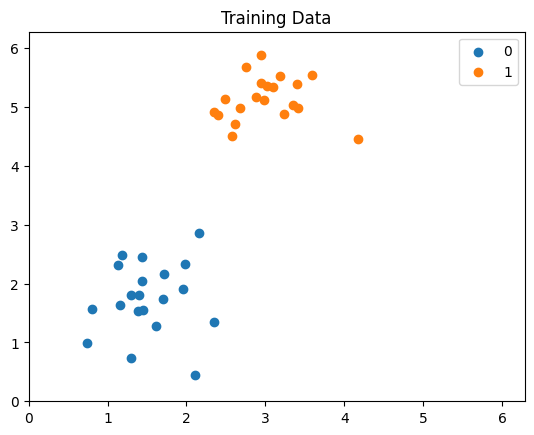

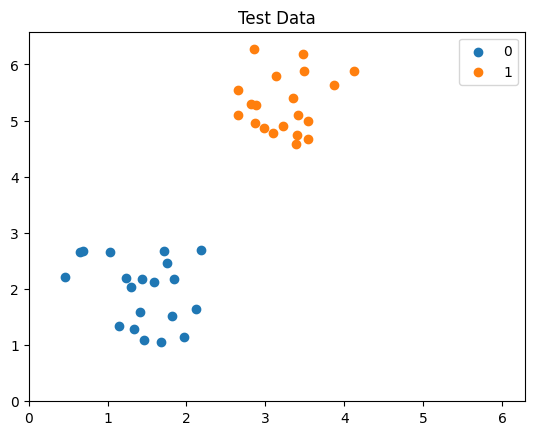

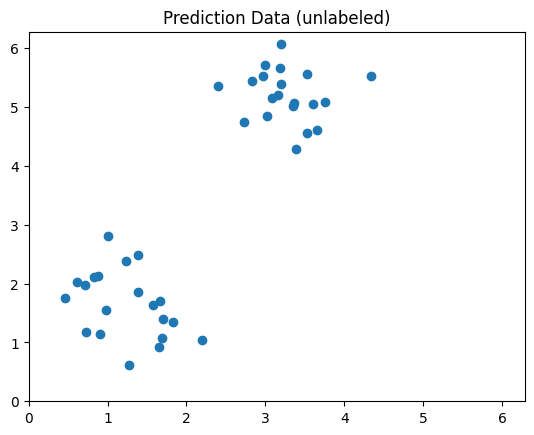

In [35]:
# Plot the data
plot_range = (0, 2 * np.pi)

for k, v in training_input.items():
    plt.scatter(*v.T, label=str(k))
plt.legend()
plt.title("Training Data")
plt.xlim(plot_range)
plt.ylim(plot_range)
plt.show()

for k, v in test_input.items():
    plt.scatter(*v.T, label=str(k))
plt.legend()
plt.title("Test Data")
plt.xlim(plot_range)
plt.ylim((0, 2 * np.pi + 0.3))
plt.show()

plt.scatter(*predict_input.T)
plt.title("Prediction Data (unlabeled)")
plt.xlim(plot_range)
plt.ylim(plot_range)
plt.show()

### Defining the Feature Map
When constructing a QSVM model, we must supply the feature map which.

A feature map is a way to encode classical data into quantum.
Here, we choose to encode the data onto the surface of the Bloch sphere.


This can be defined in terms of the following transformation on the 2D data point $$\mathbf{x} = [x_0,x_1]^T\rightarrow R_Z(x_1) R_X(x_0/2)|0\rangle = \cos(x_0/4)|0\rangle + e^{x_1/4}\sin(x_0/4)|1\rangle~~,$$
where the circuit takes a single qubit per data point and the last equality is up to a global phase. We define a quantum function that generalizes the Bloch sphere mapping to an input vector of any dimension (also known as "dense angle encoding" in the field of quantum neural networks). Each pair of entries in the vector is mapped to a Bloch sphere. If there is an odd size, we apply a single RX gate on an extra qubit.

Since a single qubit stores the data of a single data point, for such a feature mapping the number of qubits required is $n=2\lceil m d/2 \rceil$.

In [6]:
from classiq.qmod.symbolic import ceiling, floor


@qfunc
def bloch_feature_map(data: CArray[CReal], qba: QArray):
    repeat(ceiling(data.len / 2), lambda i: RX(data[2 * i] / 2, qba[i]))
    repeat(floor(data.len / 2), lambda i: RZ(data[(2 * i) + 1], qba[i]))

#### Defining the Data
In addition to the feature map, we need to prepare our data.

The `training_input` and `test_input` datasets consist of data and its labels. The labels are a 1D array where the value of the label corresponds to each data point and can be basically anything, such as (0, 1), (3, 5), or ('A', 'B').
The `predict_input` consists only of data points (without labels).


In [7]:
# Prepare and define `train_input` and `test_input` datasets consisting of data and labels
TRAIN_DATA_1, TRAIN_LABEL_1 = data_dict_to_data_and_labels(training_input)
TEST_DATA_1, TEST_LABEL_1 = data_dict_to_data_and_labels(test_input)

# Prepare and define `predict_input`
PREDICT_DATA_1 = predict_input

### Constructing a Model
We can now construct the QSVM model using the `bloch_feature_map` function, and its inverse:

In [8]:
feature_dimension = 2


@qfunc
def main(
    data1: CArray[CReal, feature_dimension],
    data2: CArray[CReal, feature_dimension],
    qba: Output[QNum[ceiling(feature_dimension / 2)]],
):
    allocate(qba)
    bloch_feature_map(data1, qba)
    invert(lambda: bloch_feature_map(data2, qba))


QSVM_BLOCH_SHPERE_qmod = create_model(main)
write_qmod(QSVM_BLOCH_SHPERE_qmod, "qsvm_bloch_sphere_feature_map", symbolic_only=False)

#### Synthesizing the Model and Exploring the Generated Quantum Circuit
Once we have constructed our QSVM model, we synthesize and view the quantum circuit that encodes our data using the Classiq built-in `synthesize` and `show` functions:

In [9]:
qprog_bloch = synthesize(main)
show(qprog_bloch)

Quantum program link: https://platform.classiq.io/circuit/37qLGCeFW0ESmibXbmnB0V76bIw


### Executing QSVM
Steps in QSVM execution:
1. Training.
2. Testing the training process, and outputing a test score.
3. Predicting, by taking unlabeled data and returning its predicted labels. This may be applied multiple times on different datasets.

Next, we define classical functions for applying the three parts of the execution process, where the third uses `ExecutionSession` and `batch_sample`.

The training and prediction procedure are performed by `train_svm` and `predict_svm` functions in four main steps:
1. The data set is composed by `get_exectuation_params` to a list of dictionaries involving all pairs of data points (not including symmetric cases).
2. Utilizing Classiq's `sample_batch` we evaluate the overlap between the states encoding the two data points of each pair.
3. The measurement results are used to construct the kernel matrix by the `construct_kernel_matrix` function.
4. The kernel matrix is utilized by scikit-learn's `SVC` (Support Vector Classifier) function to optimize the quadratic program (the dual optimization problem). The function provides an `svm_model` which contains the dual optimization problem coefficients $\{\alpha_i\}$. The knowledge of the optimized coefficients enables the model to predict the classification of a new data point, utilizing Eq. (1).
   

In the training procedure due to the symmety of the kernel matrix ($K(\mathbf{x}_i, \mathbf{x}_j) = K(\mathbf{x}_j, \mathbf{x}_i)$) the execution paramertes are both chosen from the training data set, and all the non-symmetric instances are evaluated Contrastly, following Eq. (1) the prediction procedure composes all the combinations of data point pairs, where one of the data points is from the training set and the other is from the prediction data set. 
Note that generally $K(\mathbf{x}_i, \mathbf{s}_j) \neq K(\mathbf{x}_j, \mathbf{s}_i)$, therefore, in the prediction, all the overlaps between all possible data point pairs are evaluated.

In [10]:
def get_execution_params(data1, data2=None):
    """
    Generate execution parameters based on the mode (train or validate).
    The output is a list of the form [{data1: np.ndarray, data2: np.ndarray},...],
    each dictionary contains two data points, and the output list includes all
    possible non-symmetric combinations of data points. In the training mode the data
    points are only taken from data1, while in the prediction mode, the dictionary key data1 is taken from data1 input
    and data2 key is taken from

    Parameters:
    - data1: First dataset (used for both training and validation).
    - data2: Second dataset (only required for validation).

    Returns:
    - A list of dictionaries with execution parameters

    """
    if data2 is None:
        # Training mode (symmetric pairs of data1)
        return [
            {"data1": data1[k], "data2": data1[j]}
            for k in range(len(data1))
            for j in range(k, len(data1))  # Avoid symmetric pairs
        ]
    else:
        # Prediction mode
        return [
            {"data1": data1[k], "data2": data2[j]}
            for k in range(len(data1))
            for j in range(len(data2))
        ]


def construct_kernel_matrix(matrix_size, res_batch, train=False):
    """
    Construct a kernel matrix from `res_batch`, depending on whether it's for training or predicting.

    Parameters:
    - matrix_size: Tuple of (number of rows, number of columns) for the matrix.
    - res_batch: Precomputed batch results.
    - train: Boolean flag. If True, assumes training (symmetric matrix).

    Returns:
    - A kernel matrix as a NumPy array.
    """
    rows, cols = matrix_size
    kernel_matrix = np.zeros((rows, cols))

    num_shots = res_batch[0].num_shots
    num_output_qubits = len(next(iter(res_batch[0].counts)))

    count = 0
    if train:  # and rows == cols:
        # Symmetric matrix (training)
        for k in range(rows):
            for j in range(k, cols):
                # Empirical probability to measure the state |0...0>
                value = (
                    res_batch[count].counts.get("0" * num_output_qubits, 0) / num_shots
                )
                kernel_matrix[k, j] = value
                kernel_matrix[j, k] = value  # Use symmetry
                count += 1
    else:
        # Non-symmetric matrix (validation)
        for k in range(rows):
            for j in range(cols):
                kernel_matrix[k, j] = (
                    res_batch[count].counts.get("0" * num_output_qubits, 0) / num_shots
                )
                count += 1

    return kernel_matrix


def train_svm(es, train_data, train_labels):
    """
    Trains an SVM model using a custom precomputed kernel from the training data.

    Parameters:
    - es: ExecutionSession object to process batch execution for kernel computation.
    - train_data: List of data points for training.
    - train_labels: List of binary labels corresponding to the training data.

    Returns:
    - svm_model: A trained SVM model using the precomputed kernel.
    """
    train_size = len(train_data)
    train_execution_params = get_execution_params(train_data)
    res_train_batch = es.batch_sample(train_execution_params)  # execute batch
    # generate kernel matrix for train
    kernel_train = construct_kernel_matrix(
        matrix_size=(train_size, train_size), res_batch=res_train_batch, train=True
    )
    svm_model = SVC(kernel="precomputed")
    svm_model.fit(
        kernel_train, train_labels
    )  # the fit gets the precomputed matrix of training, and the training labels

    return svm_model


def predict_svm(es, data, train_data, svm_model):
    """
    Predicts labels for new data using a precomputed kernel with a trained SVM model.

    Parameters:
    - es: ExecutionSession object to process batch execution for kernel computation.
    - data (list): List of new data points to predict.
    - train_data (list): Original training data used to train the SVM.
    - svm_model: A trained SVM model returned by `train_svm`.

    Returns:
    - y_predict (list): Predicted labels for the input data.
    """
    predict_size = len(data)
    train_size = len(train_data)
    predict_execution_params = get_execution_params(data, train_data)
    res_predict_batch = es.batch_sample(predict_execution_params)  # execute batch
    kernel_predict = construct_kernel_matrix(
        matrix_size=(predict_size, train_size), res_batch=res_predict_batch, train=False
    )
    y_predict = svm_model.predict(
        kernel_predict
    )  # the predict gets the precomputed test matrix

    return y_predict

We can now run the execution session with all three parts:

In [11]:
from classiq.execution import ExecutionSession

with ExecutionSession(qprog_bloch) as es:
    # train
    svm_model = train_svm(es, TRAIN_DATA_1.tolist(), TRAIN_LABEL_1.tolist())

    # test
    y_test = predict_svm(es, TEST_DATA_1.tolist(), TRAIN_DATA_1.tolist(), svm_model)
    test_score = sum(y_test == TEST_LABEL_1.tolist()) / len(TEST_LABEL_1.tolist())

    # predict
    predicted_labels = predict_svm(
        es, PREDICT_DATA_1.tolist(), TRAIN_DATA_1.tolist(), svm_model
    )

### Results

We can view the classification accuracy through `test_score`, moreover, since this data was previously generated, we also know the real labels and can print them for comparison.

In [12]:
# Printing tests result
print(f"Testing success ratio: {test_score}")
print()
# Printing predictions
print("Prediction from datapoints set:")
print(f"  ground truth: {predict_real_labels}")
print(f"  prediction:   {predicted_labels}")
print(
    f"  success rate: {100 * np.count_nonzero(predicted_labels == predict_real_labels) / len(predicted_labels)}%"
)

Testing success ratio: 1.0

Prediction from datapoints set:
  ground truth: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1]
  prediction:   [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1]
  success rate: 100.0%


We can even visualize the predicted results:

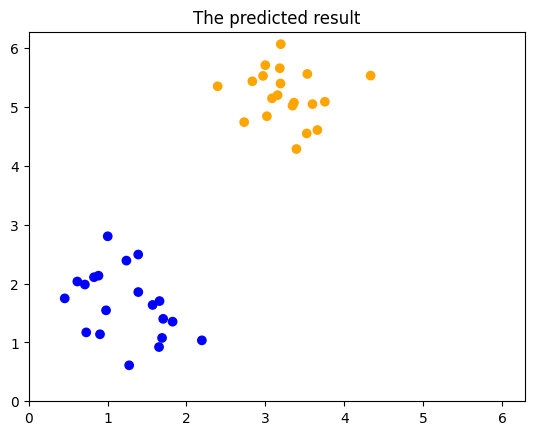

In [13]:
# Plotting
COLORS = ["blue", "orange"]
plt.scatter(
    *zip(*predict_input),
    color=np.vectorize(COLORS.__getitem__)(predicted_labels),
)
plt.title("The predicted result")
plt.xlim(plot_range)
plt.ylim(plot_range)
plt.show()

## Example 2: Puali and Bloch Sphere Feature Map on a Complex Data Set

We begin by importing the relevant software packages

In [14]:
from itertools import combinations, islice

from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.datasets import ad_hoc_data

We consider a more complicated classification task, utilizing qiskit's ad_hoc_data, we generate a data set which can be fully separated by ZZ feature map [[3](#)] 

In [15]:
seed = 12345
algorithm_globals.random_seed = seed

adhoc_dimension = 2

TRAIN_DATA_2, TRAIN_LABELS_2, test_features, test_labels, ad_hoc_total = ad_hoc_data(
    training_size=20,
    test_size=5 + 5,  # 5 for test, 5 for predict
    n=adhoc_dimension,
    gap=0.3,
    plot_data=False,
    one_hot=False,
    include_sample_total=True,
)

Next we split the test features and labels to a test and prediction set.

In [16]:
# the sizes of the `test_features` and `test_labels` are double those of the `test_size` argument
# Since there are `test_size` items for each `adhoc_dimension`


def split(obj: np.ndarray, n: int = 20):
    quarter = n // 4
    half = n // 2
    first = np.concatenate((obj[:quarter], obj[half : half + quarter]))
    second = np.concatenate((obj[quarter:half], obj[half + quarter :]))
    return first, second


TEST_DATA_2, PREDICT_DATA_2 = split(test_features)
TEST_LABELS_2, predict_real_labels_2 = split(test_labels)

The data can be visualised by a color coded plot

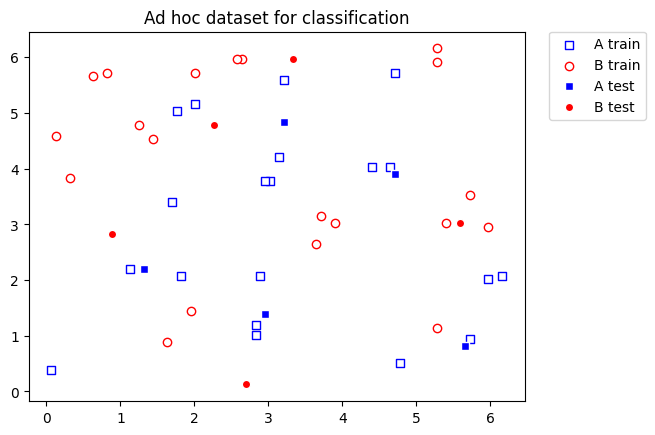

In [17]:
# Plot data
import matplotlib.pyplot as plt

plt.scatter(
    TRAIN_DATA_2[np.where(TRAIN_LABELS_2[:] == 0), 0],
    TRAIN_DATA_2[np.where(TRAIN_LABELS_2[:] == 0), 1],
    marker="s",
    facecolors="w",
    edgecolors="b",
    label="A train",
)
plt.scatter(
    TRAIN_DATA_2[np.where(TRAIN_LABELS_2[:] == 1), 0],
    TRAIN_DATA_2[np.where(TRAIN_LABELS_2[:] == 1), 1],
    marker="o",
    facecolors="w",
    edgecolors="r",
    label="B train",
)
plt.scatter(
    TEST_DATA_2[np.where(TEST_LABELS_2[:] == 0), 0],
    TEST_DATA_2[np.where(TEST_LABELS_2[:] == 0), 1],
    marker="s",
    facecolors="b",
    edgecolors="w",
    label="A test",
)
plt.scatter(
    TEST_DATA_2[np.where(TEST_LABELS_2[:] == 1), 0],
    TEST_DATA_2[np.where(TEST_LABELS_2[:] == 1), 1],
    marker="o",
    facecolors="r",
    edgecolors="w",
    label="B test",
)

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.title("Ad hoc dataset for classification")

plt.show()

### Pauli Feature Map

We build a Pauli feature map. This feature map is of size $N$ qubits for data $\mathbf{x}$ of size $N$, and it corresponds to the following unitary:
$$
U = \left(\hbox{Hadamarad Transform}\right) \exp\left(\sum f^{(1)}_k(\mathbf{x})H^{(1)}_k + \sum f^{(2)}_k(\mathbf{x})H^{(2)}_k+\dots \right)~~,
$$
where $H^{(i)}$ is a Hamiltonian acting on $i$ qubits according to some connectivity map, and $f^{(i)}$ is some classical function, typically taken as the polynomial of degree $i$. For example, if our data is of size $3$ and we assume circular connectivity, taking Hamiltonians depending only on $Z$, the Hamiltonian reads as
$$
\sum f^{(1)}_k(\mathbf{x})H^{(1)}_k = \alpha(x_0+\beta)ZII+\alpha(x_1+\beta)IZI+\alpha(x_2+\beta)IIZ,
$$
$$
\sum f^{(2)}_k(\mathbf{x})H^{(2)}_k = \gamma^2(x_0+\zeta)(x_1+\zeta)ZZI+\gamma^2(x_1+\zeta)(x_2+\zeta)IZZ + \gamma^2(x_0+\zeta)(x_3+\zeta)ZIZ~~,
$$
where $(\alpha,\beta)$ and $(\gamma,\zeta)$ define some affine transformation on the data and correspond to the functions $f^{(1,2)}$.

We start by defining classical functions for creating a connectivity map for the Hamiltonians and for generating the full Hamiltonian:

In [18]:
def generate_connectivity_map(list_size, sublist_size, connectivity_type):
    """
    Generate connectivity for a given list size and sublist size.

    Parameters:
    - list_size: The size of the list (number of elements).
    - sublist_size: The size of the subsets to generate.
    - connectivity_type: an integer (0 for linear, 1 for circular, 2 for full)

    Returns:
    - A list of all unique subsets of the given size.
    """
    assert connectivity_type in [
        0,
        1,
        2,
    ], "connectivity must be 0 (linear), 1 (circular), or 2 (full)"

    if connectivity_type == 0:  # linear
        return [
            list(range(i, i + sublist_size))
            for i in range(list_size - sublist_size + 1)
        ]

    elif connectivity_type == 1:  # circular
        return [
            [(i + j) % list_size for j in range(sublist_size)] for i in range(list_size)
        ]

    elif connectivity_type == 2:  # full
        return [list(comb) for comb in combinations(range(list_size), sublist_size)]


def generate_hamiltonian(
    data: CArray[CReal],
    paulis_list: list[list[Pauli]],
    affines: list[list[float]],
    connectivity: int,
) -> tuple[list[SparsePauliOp], list[CReal]]:
    assert connectivity in [
        0,
        1,
        2,
    ], "connectivity must be 0 (linear), 1 (circular) or 2 (full)"
    hs = []
    coeffs = []
    for paulis, affine in zip(paulis_list, affines):
        indices = generate_connectivity_map(data.len, len(paulis), connectivity)
        for k in range(len(indices)):
            indexed_paulis = [
                IndexedPauli(pauli=paulis[j], index=indices[k][j])
                for j in range(len(indices[0]))
            ]
            hs.append(
                SparsePauliOp(
                    terms=[SparsePauliTerm(paulis=indexed_paulis, coefficient=1)],
                    num_qubits=data.len,
                )
            )
            coe = np.prod(
                [
                    affine[0] * (data[indices[k][j]] - affine[1])
                    for j in range(len(indices[0]))
                ]
            )
            coeffs.append(coe)

    return hs, coeffs

Next, we define a quantum function for the Pauli feature map:

In [19]:
@qfunc
def pauli_kernel(
    data: CArray[CReal],
    paulis_list: list[list[Pauli]],
    affines: list[list[float]],
    connectivity: int,
    reps: CInt,
    qba: QArray,
) -> None:
    hs, coeffs = generate_hamiltonian(data, paulis_list, affines, connectivity)
    power(
        reps,
        lambda: (
            hadamard_transform(qba),
            multi_suzuki_trotter(
                hamiltonians=hs,
                evolution_coefficients=coeffs,
                order=1,
                repetitions=1,
                qbv=qba,
            ),
        ),
    )

Finally, we construct the quantum model for the QSVM routine:

In [20]:
N_DIM = 2
PAULIS = [[Pauli.Z], [Pauli.Z, Pauli.Z]]
CONNECTIVITY = 2
AFFINES = [[1, 0], [1, np.pi]]
REPS = 2

In [21]:
@qfunc
def main(data1: CArray[CReal, N_DIM], data2: CArray[CReal, N_DIM], qba: Output[QNum]):
    allocate(data1.len, qba)
    pauli_kernel(data1, PAULIS, AFFINES, CONNECTIVITY, REPS, qba)
    invert(lambda: pauli_kernel(data2, PAULIS, AFFINES, CONNECTIVITY, REPS, qba))


QSVM_PAULI_Z_ZZ = create_model(main)
write_qmod(QSVM_PAULI_Z_ZZ, "qsvm_pauli_feature_map", symbolic_only=False)

### Viewing the Model's Parameterized Quantum Circuit

In [22]:
qprog_pauli = synthesize(main)
show(qprog_pauli)

Quantum program link: https://platform.classiq.io/circuit/37qLKOEyb6gqJkON866KR3ewleP


### Executing QSVM
Similarly to the previous example, we first train, then test and evaluate the quality of classification, and finally perform predictions on an unlabelled data set.

We can now run the execution session with all three parts, first for the Pauli feature map and then for the Bloch sphere map.

In [24]:
with ExecutionSession(qprog_pauli) as es:
    # train
    svm_model_pauli = train_svm(es, TRAIN_DATA_2.tolist(), TRAIN_LABELS_2.tolist())

    # test
    y_test_pauli = predict_svm(
        es, TEST_DATA_2.tolist(), TRAIN_DATA_2.tolist(), svm_model_pauli
    )
    test_score_pauli = sum(y_test_pauli == TEST_LABELS_2.tolist()) / len(
        TEST_LABELS_2.tolist()
    )
    # print("quantum kernel classification test score:  %0.2f" % (test_score))

    # predict
    predicted_labels_pauli = predict_svm(
        es, PREDICT_DATA_2.tolist(), TRAIN_DATA_2.tolist(), svm_model_pauli
    )

In [26]:
with ExecutionSession(qprog_bloch) as es:
    # train
    svm_model_bloch = train_svm(es, TRAIN_DATA_2.tolist(), TRAIN_LABELS_2.tolist())

    # test
    y_test_bloch = predict_svm(
        es, TEST_DATA_2.tolist(), TRAIN_DATA_2.tolist(), svm_model_bloch
    )
    test_score_bloch = sum(y_test_bloch == TEST_LABELS_2.tolist()) / len(
        TEST_LABELS_2.tolist()
    )

    # predict
    predicted_labels_bloch = predict_svm(
        es, PREDICT_DATA_2.tolist(), TRAIN_DATA_2.tolist(), svm_model_bloch
    )

### Results

The Pauli feature map accurately classifies the test and prediction data sets.

In [29]:
# Printing tests result
print(f"Testing success ratio for the Pauli feature map: {test_score_pauli}")
print()
# Printing predictions
print("Prediction from datapoints set:")
print(f"  ground truth: {predict_real_labels_2}")
print(f"  prediction:   {predicted_labels_pauli}")
print(
    f"  success rate: {100 * np.count_nonzero(predicted_labels_pauli == predict_real_labels_2) / len(predicted_labels_pauli)}%"
)

Testing success ratio for the Pauli feature map: 1.0

Prediction from datapoints set:
  ground truth: [0 0 0 0 0 1 1 1 1 1]
  prediction:   [0 0 0 0 0 1 1 1 1 1]
  success rate: 100.0%


In comparison, the Bloch sphere feature map manages to classify 60% of the test data set and only half of the prediction data set.

In [30]:
# Printing tests result
print(f"Testing success ratio for the Bloch sphere feature map: {test_score_bloch}")
print()
# Printing predictions
print("Prediction from datapoints set:")
print(f"  ground truth: {predict_real_labels_2}")
print(f"  prediction:   {predicted_labels_bloch}")
print(
    f"  success rate: {100 * np.count_nonzero(predicted_labels_bloch == predict_real_labels_2) / len(predicted_labels_bloch)}%"
)

Testing success ratio for the Bloch sphere feature map: 0.6

Prediction from datapoints set:
  ground truth: [0 0 0 0 0 1 1 1 1 1]
  prediction:   [1 1 0 0 0 1 1 0 0 0]
  success rate: 50.0%


## Summary and Discussion

The notebook demonstrated the application of the Quantum Support Vector Machine (QSVM) algorithm to supervised data classification tasks. Two datasets were analyzed using two distinct quantum feature maps: a Bloch-sphere–based encoding and a Pauli-based feature map. The Bloch-sphere mapping achieved perfect classification accuracy on a linearly separable dataset but showed only moderate performance when applied to a more complex, nonlinearly separable dataset. In contrast, the Pauli feature map successfully captured the structure of the complex dataset and yielded accurate classification results.

These results emphasize a central consideration in QSVM design: the choice of quantum feature map plays a decisive role in model performance. Effective alignment between the feature map and the underlying structure of the data is essential for achieving high classification accuracy.

## Reference

<a id='learning'>[1]</a> [Havl&#237;&#269;ek, V., C&#243;rcoles, A.D., Temme, K. et al. Supervised learning with quantum-enhanced feature spaces. Nature 567, 209-212 (2019).](https://doi.org/10.1038/s41586-019-0980-2)

<a id='KKT'>[2]</a> [Karush–Kuhn–Tucker conditions](https://en.wikipedia.org/wiki/Karush%E2%80%93Kuhn%E2%80%93Tucker_conditions)

<a id='qFeatureSpaces'>[3]</a>[Havlíček, V., Córcoles, A. D., Temme, K., Harrow, A. W., Kandala, A., Chow, J. M., & Gambetta, J. M. (2019). Supervised learning with quantum-enhanced feature spaces. Nature, 567(7747), 209-212.](https://arxiv.org/abs/1804.11326)
